In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("igno4re",category=RuntimeWarning)

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import seaborn as sns
sns.set()
import matplotlib
from IPython.display import set_matplotlib_formats

matplotlib.rc('font', family='NanumGothic')

matplotlib.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

In [4]:
print(train.shape)
train.head(5)

(1459, 11)


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [6]:
## target에 대한 통계량 확인
train['count'].describe()

count    1459.000000
mean      108.563400
std        82.631733
min         1.000000
25%        37.000000
50%        96.000000
75%       150.000000
max       431.000000
Name: count, dtype: float64

* 베이스라인 모델
    * simple Linear Regression

In [7]:
from sklearn.model_selection import train_test_split

features = train.dropna().loc[:,:"hour_bef_pm2.5"]
target = train.dropna()['count']

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3)

# baseline model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

base_model = LinearRegression()

base_model.fit(X_train,y_train)

base_pred = base_model.predict(X_test)

base_scores = cross_val_score(base_model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
base_rmse_scores = np.sqrt(-1*base_scores)
base_rmse = np.mean(base_rmse_scores)
base_r2 = r2_score(base_pred,y_test)

print("base model rmse : ",base_rmse)
print("base model r2 : ",base_r2)

base model rmse :  53.32160721781468
base model r2 :  0.2594596567484485


* base model의 회귀계수 시각화

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


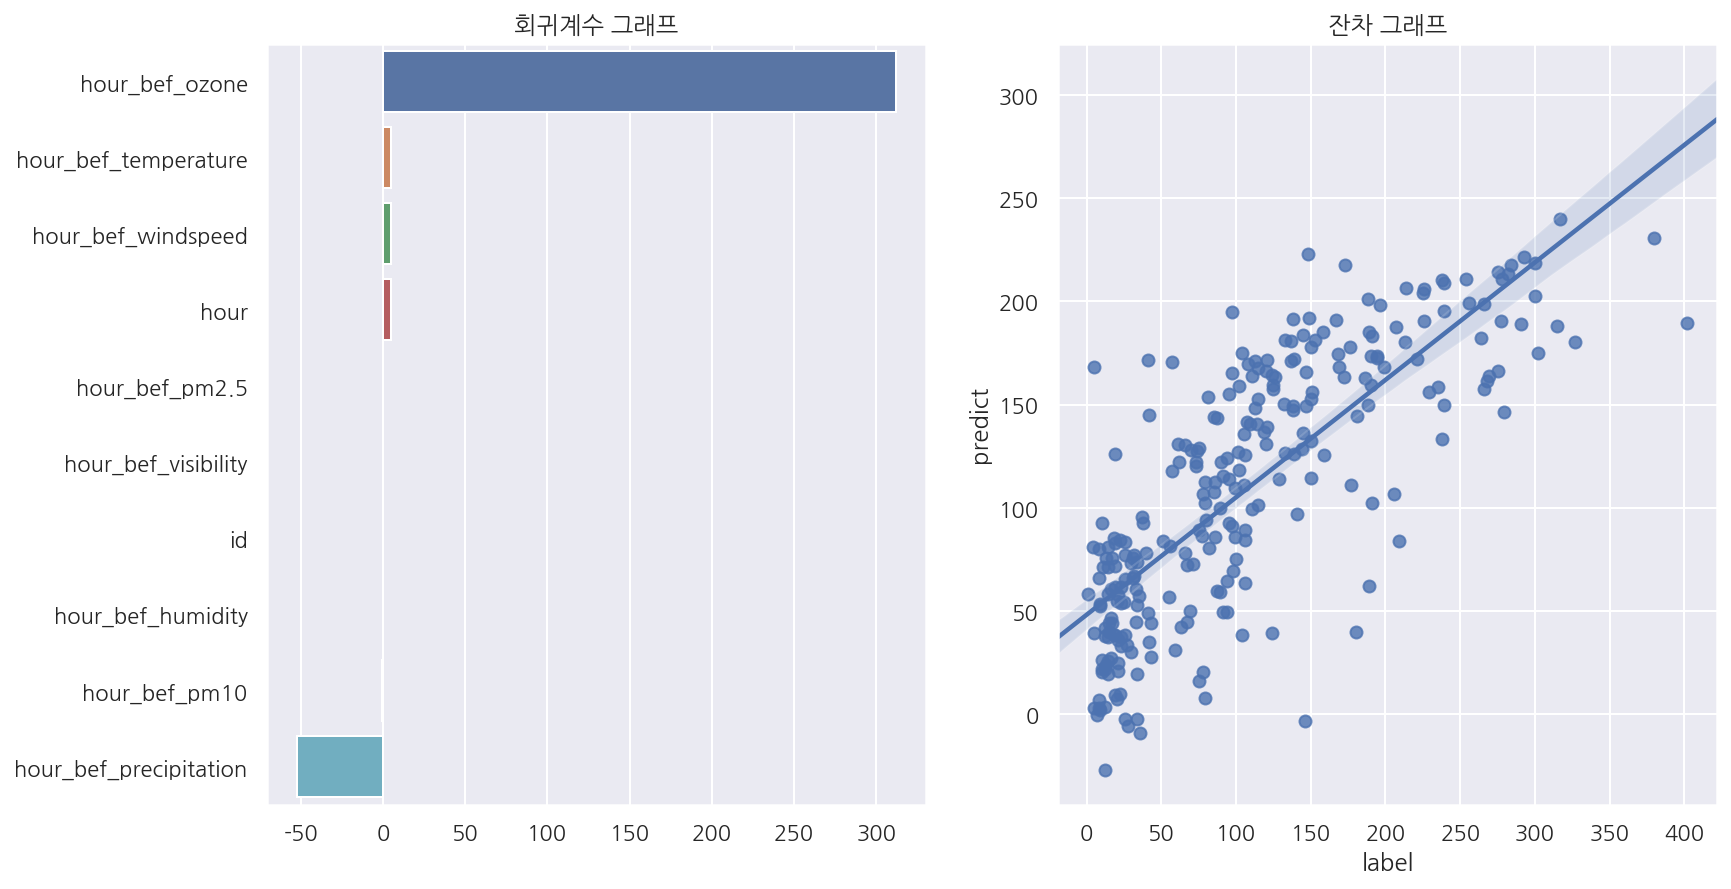

In [8]:
## 회귀계수 그래프
coef = pd.Series(base_model.coef_, index=features.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(base_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

* simple Feature Engineering & modeling version 1
    * 단순 식별자인 id 컬럼 제거
    * 데이터 표준화 진행
    * hour 피처의 원-핫 인코딩

Text(0.5, 1.0, '시간대별 대여횟수 평균')

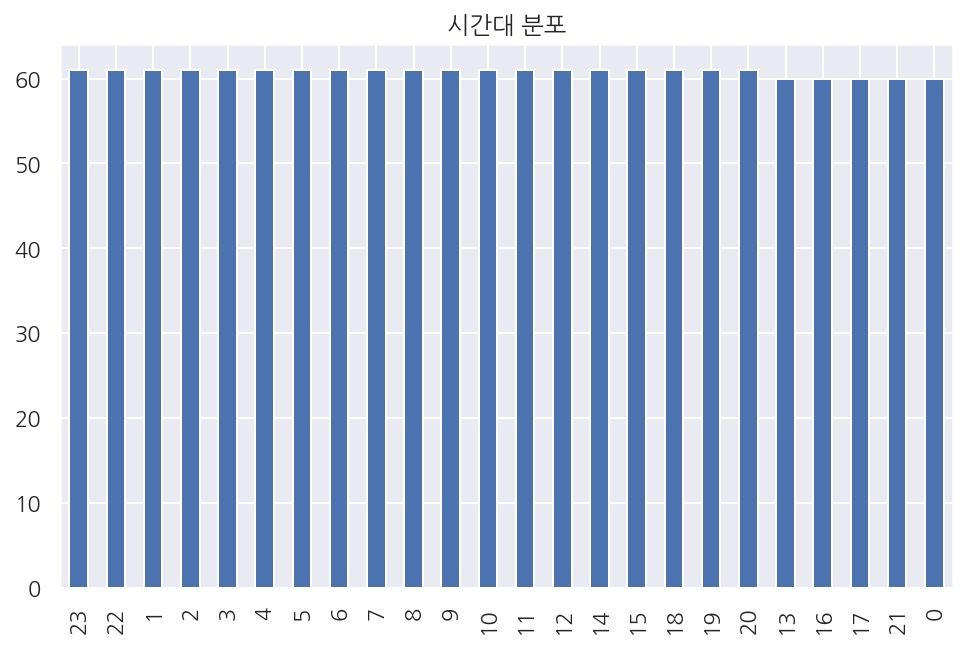

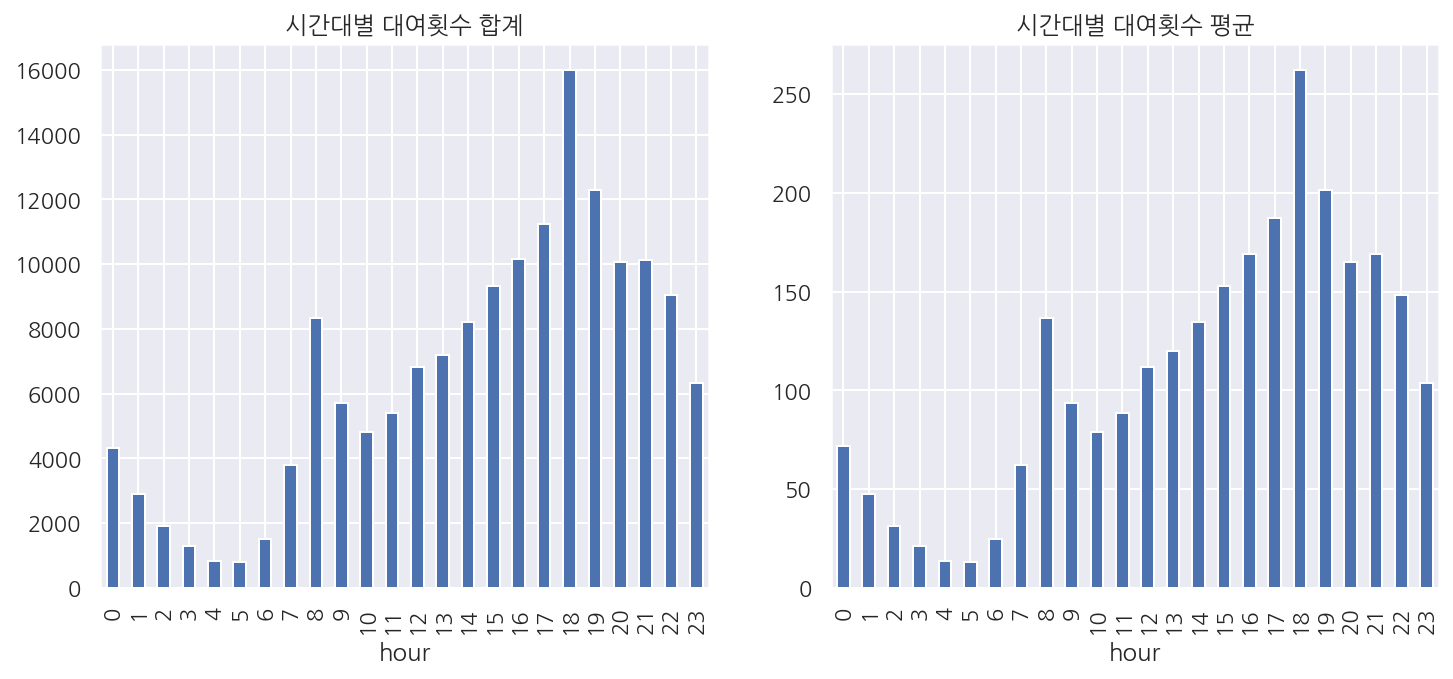

In [9]:
# 시간대 분포
plt.figure(figsize=(8,5))
train['hour'].value_counts().plot(kind='bar')
plt.title("시간대 분포")

# 시간대별 대여횟수 분포 # 합계
plt.figure(figsize=(12,5))
plt.subplot(121)
train.groupby('hour')['count'].sum().plot(kind='bar')
plt.title("시간대별 대여횟수 합계")

# 시간대별 대여횟수 분포 # 평균
plt.subplot(122)
train.groupby('hour')['count'].mean().plot(kind='bar')
plt.title("시간대별 대여횟수 평균")

* 시간대의 경우 0~24시가 균등하게 분포하고 있음
* 시간대별 대여횟수의 경우 시간대별로 확연한 차이가 보임.
    * 0~6시까지는 가장 낮은 대여횟수를 보이며 감소추세임.
    * 7,8시부터 다시 대여횟수가 증가함. 또, 17,18,19시에 가장 높은 대여횟수를 가지는것으로 보아 출퇴근시에 따릉이를 이용하는 사람들이 많은것으로 보임.
* 시간대별로 확연한 차이가 보이므로 원-핫 인코딩을 통해 개별 피처로 활용할것.

In [10]:
from sklearn.preprocessing import StandardScaler

# 전처리 후 train/test 반환
## 단순 식별자인 id컬럼 제거
## 데이터 표준화 진행
def data_preprocessing(data):
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = data.dropna().loc[:,:"hour_bef_pm2.5"] # 결측값 제거 # 피처 선택
    target = data.dropna()['count'] # target
    
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    
    res_df = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_df[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(res_df,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,res_df

    
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing(train)   


# model _ 1
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

model_1 = LinearRegression()

model_1.fit(X_train,y_train)

model_1_pred = model_1.predict(X_test)

model_1_scores = cross_val_score(model_1, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_1_rmse_scores = np.sqrt(-1*model_1_scores)
model_1_rmse = np.mean(model_1_rmse_scores)
model_1_r2 = r2_score(model_1_pred,y_test)

print("model_1 rmse : ",model_1_rmse)
print("model_1 r2 : ",model_1_r2)

model_1 rmse :  42.07340535856227
model_1 r2 :  0.5881847312533034


In [11]:
## 전처리 적용 후의 data
res_df.head(5)

,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,hour_0,hour_2,hour_3,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_bef_precipitation_0.0,hour_bef_precipitation_1.0
0,-0.108967,-0.716090,1.848215,-1.451638,-0.622533,0.593375,0.177633,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.622564,-0.788435,-0.185569,-0.862425,0.149769,0.497250,0.652684,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.570987,-1.294846,1.352170,-0.054858,-0.313612,-0.816461,-0.772469,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-1.687533,0.152043,0.112058,-0.810436,0.046796,0.561333,2.281431,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,2.432140,1.671277,-2.219352,1.016123,0.922071,-0.976669,-1.315385,0,0,0,...,0,0,1,0,0,0,0,0,1,0


* 간단한 데이터 전처리만으로도 base model에 비해 예측성능이 크게 향상되었음.

* 각 피처의 회귀계수 값을 시각화해 본다.

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


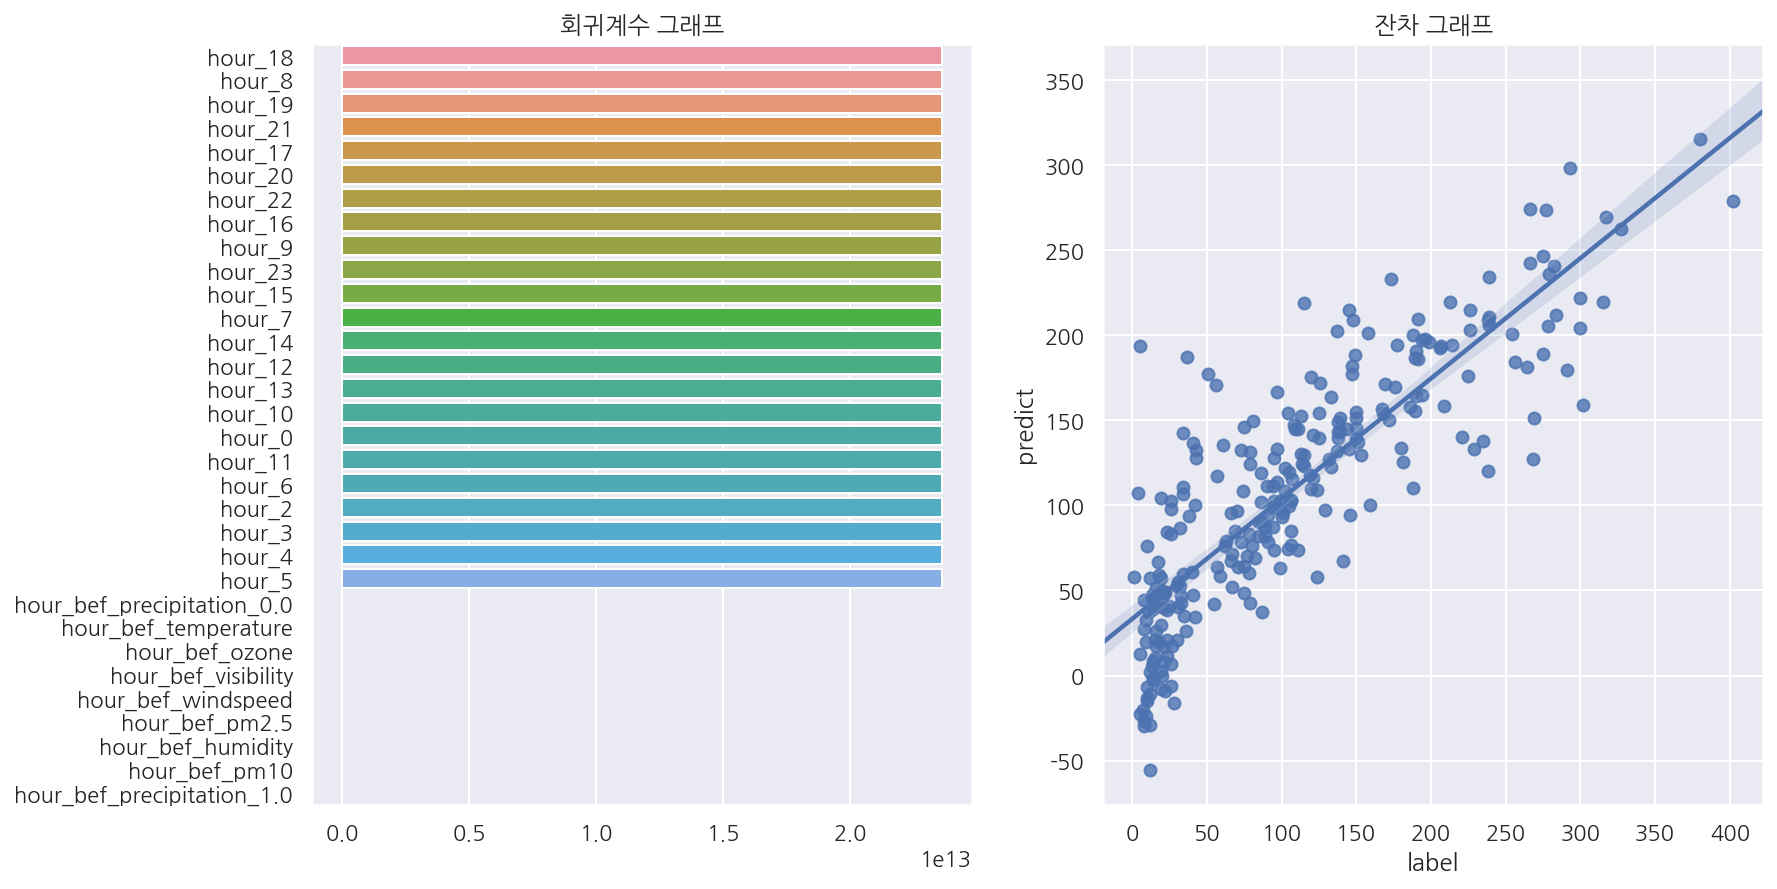

In [12]:
## 회귀계수 그래프
coef = pd.Series(model_1.coef_, index=res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_1_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

* hour 피처들의 회귀 계수가 높다. (hour 외에는 크게 영향을 미치는 피처가 없다..)
* hour들의 회귀계수가 전부 동일하게 계산되었다. 아마 무언가 잘못되었을 가능성이 큰.... 우선 진행해보고 차후에 검증해보자..

* model_1의 데이터 전처리 과정에 결측값에 대한 부분이 빠져있다.
* 결측값에 대한 전처리를 진행한 후 model_2를 만들어본다.

In [13]:
## 결측치 파악
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

* 모든 피처가 각 시간대의 정보를 담고 있다.
* 따라서 해당 피처의 시간대별 평균치로 결측값을 대체한다.
    * 단, 우천 여부를 나타내는 hour_bef_precipitation 컬럼의 경우 삭제한다.
    * ozone, pm10, pm2.5의 경우 1시에 측정된 값이 모두 결측치이다. 앞뒤 시간인 0,2시의 평균치로 대체한다.

In [14]:
# 1차
# 각 시간대별 평균값으로 결측치 대체
train['hour_bef_temperature'].fillna(train.groupby('hour')['hour_bef_temperature'].transform('mean'),inplace=True)
train['hour_bef_windspeed'].fillna(train.groupby('hour')['hour_bef_windspeed'].transform('mean'),inplace=True)
train['hour_bef_humidity'].fillna(train.groupby('hour')['hour_bef_humidity'].transform('mean'),inplace=True)
train['hour_bef_visibility'].fillna(train.groupby('hour')['hour_bef_visibility'].transform('mean'),inplace=True)
train['hour_bef_ozone'].fillna(train.groupby('hour')['hour_bef_ozone'].transform('mean'),inplace=True)
train['hour_bef_pm10'].fillna(train.groupby('hour')['hour_bef_pm10'].transform('mean'),inplace=True)
train['hour_bef_pm2.5'].fillna(train.groupby('hour')['hour_bef_pm2.5'].transform('mean'),inplace=True)

# 1차 결측치 삭제 후, ozone, pm10, pm2.5의 hour_1에 해당하는 결측치와 hour_bef_precipitation 결측치만 남음.
# ozone, pm10, pm2.5 결측값을 hour_0, hour_2의 평균값으로 대체
for col in ['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']:
    hour_0 = train[train['hour'] == 0][col].mean()
    hour_2 = train[train['hour'] == 2][col].mean()
    res = np.mean([hour_0,hour_2])
    train[col] = train[col].fillna(res)
    
# hour_bef_precipitation 결측치 삭제
train = train.dropna()

In [15]:
## 결측치 대체 후 
train.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

* 결측치 제거 완료 후, model_2 진행

In [16]:
from sklearn.preprocessing import StandardScaler

# 전처리 후 train/test 반환
## 단순 식별자인 id컬럼 제거
## 데이터 표준화 진행
def data_preprocessing(df):
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = df.loc[:,:"hour_bef_pm2.5"] # 결측값 제거 # 피처 선택
    target = df['count'] # target
    
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    
    res_df = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_df[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(res_df,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,res_df

    
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing(train)   


# model _ 2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

model_2 = LinearRegression()

model_2.fit(X_train,y_train)

model_2_pred = model_2.predict(X_test)

model_2_scores = cross_val_score(model_2, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_2_rmse_scores = np.sqrt(-1*model_2_scores)
model_2_rmse = np.mean(model_2_rmse_scores)
model_2_r2 = r2_score(model_2_pred,y_test)

print("model_2 rmse : ",model_2_rmse)
print("model_2 r2 : ",model_2_r2)

model_2 rmse :  43.490737676438876
model_2 r2 :  0.73662535371148


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


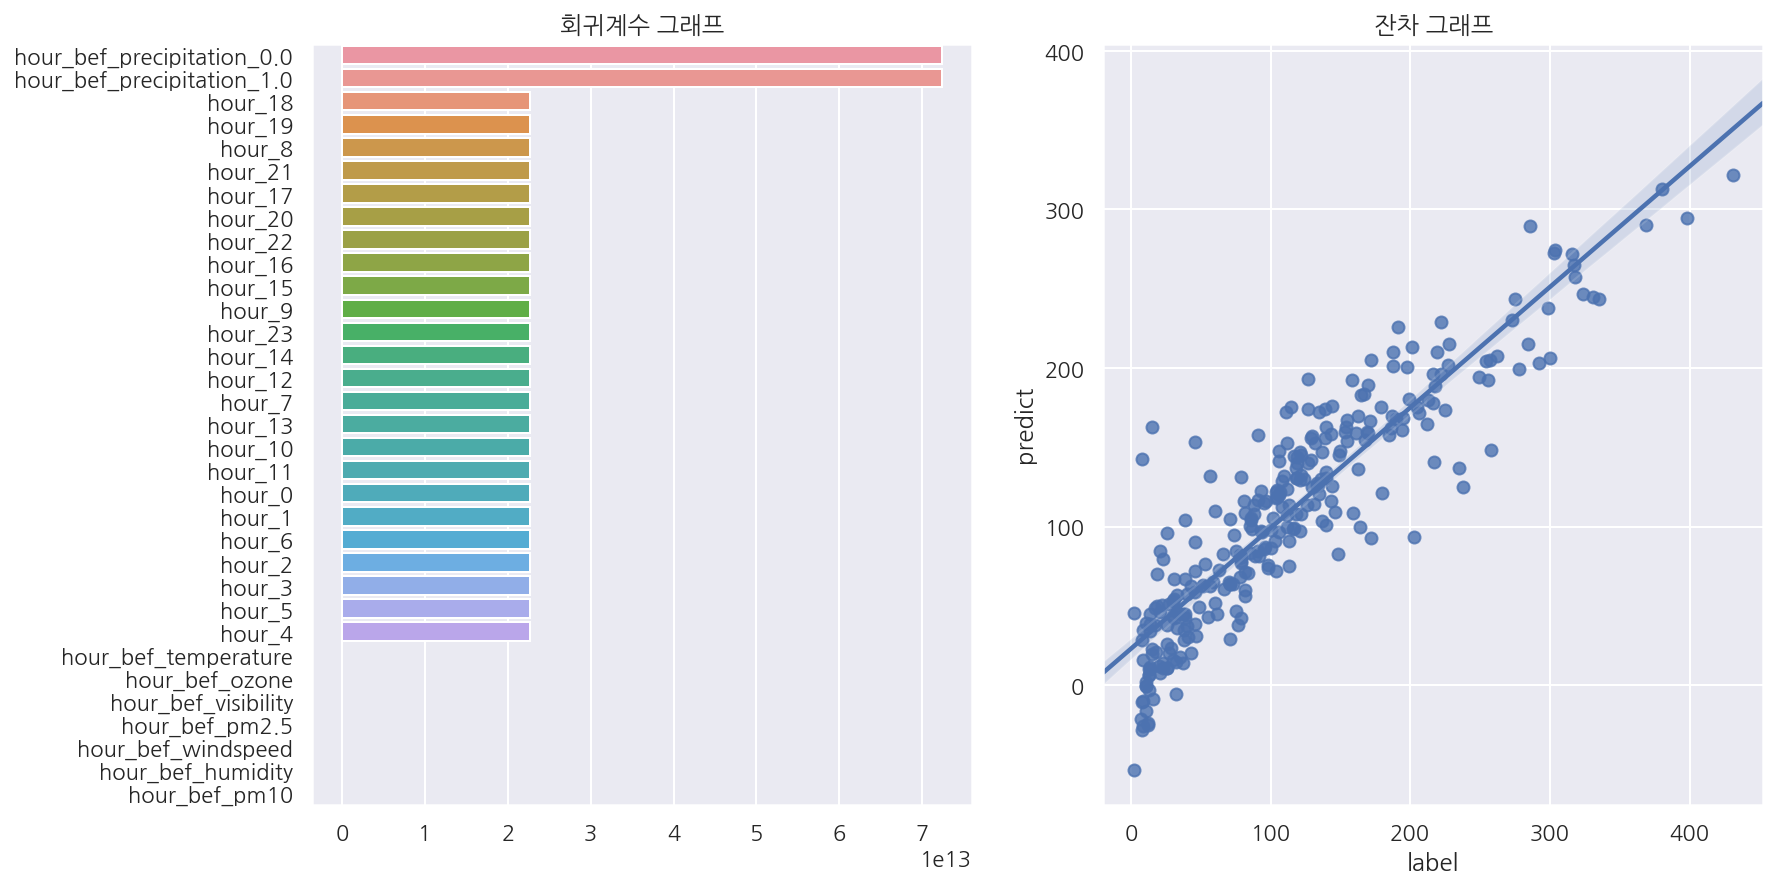

In [17]:
## 회귀계수 그래프
coef = pd.Series(model_2.coef_, index=res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_2_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

* 결측값에 대한 전처리 후 r2값이 0.73으로 모델의 설명력이 크게 상승하였다.
* 회귀계수를 살펴보면 우천여부에 대한 피처가 높은 값을 보이는것을 알 수 있다.
    * 강수 여부가 자전거 대여에 큰 영향을 끼치는것은 당연해 보인다.

* 이제 LinearRegression 외에 Ridge,Lasso, Elastic Net 등 규제 선형 모델과 비선형 모델 또한 실험해 본다.

In [18]:
# Ridge / Lasso / Elastic Net

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge,Lasso,ElasticNet

def find_best_params(data, model, params):
    
    X_train,X_test,y_train,y_test,res_df = data_preprocessing(data)
    
    grid_model = GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=3)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 3 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                             np.round(rmse,4),grid_model.best_params_))
    
    
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 10, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}   
elastic_params = {'alpha':[0.001,0.05, 0.1, 0.5, 1],
                 'l1_ratio':[0.1,0.5,1,5]}

find_best_params(train,ridge,ridge_params)
find_best_params(train,lasso,lasso_params)
find_best_params(train,elastic,elastic_params)

Ridge 3 CV 시 최적 평균 RMSE 값:43.507, 최적 alpha:{'alpha': 1}


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26920.75598864816, tolerance: 522.643418556701
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58675.365070909145, tolerance: 492.21581338481326
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39364.33999418642, tolerance: 546.2543763191763
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6603.276915156748, tolerance: 546.254376319

Lasso 3 CV 시 최적 평균 RMSE 값:43.5053, 최적 alpha:{'alpha': 0.03}


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26920.75598864816, tolerance: 522.643418556701
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58675.365070909145, tolerance: 492.21581338481326
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39364.33999418642, tolerance: 546.2543763191763
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 522.643418556701
  positive

ElasticNet 3 CV 시 최적 평균 RMSE 값:43.5011, 최적 alpha:{'alpha': 0.001, 'l1_ratio': 0.1}


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1117314.0562642962, tolerance: 522.643418556701
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1087807.4125972614, tolerance: 492.21581338481326
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1151828.5200332738, tolerance: 546.2543763191763
  positive)


In [19]:
# Ridge, Lasso의 Best Alpha값으로 훈련

# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing(train)

model_ridge = Ridge(alpha=1)
model_ridge.fit(X_train,y_train)

model_lasso = Lasso(alpha=0.03)
model_lasso.fit(X_train,y_train)

model_elastic = ElasticNet(alpha=0.001, l1_ratio=0.1)
model_elastic.fit(X_train,y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

* RMSE 값이 크게 낮아지지는 않았다.
* Ridge, Lasso, Elastic Net의 회귀계수를 살펴본다

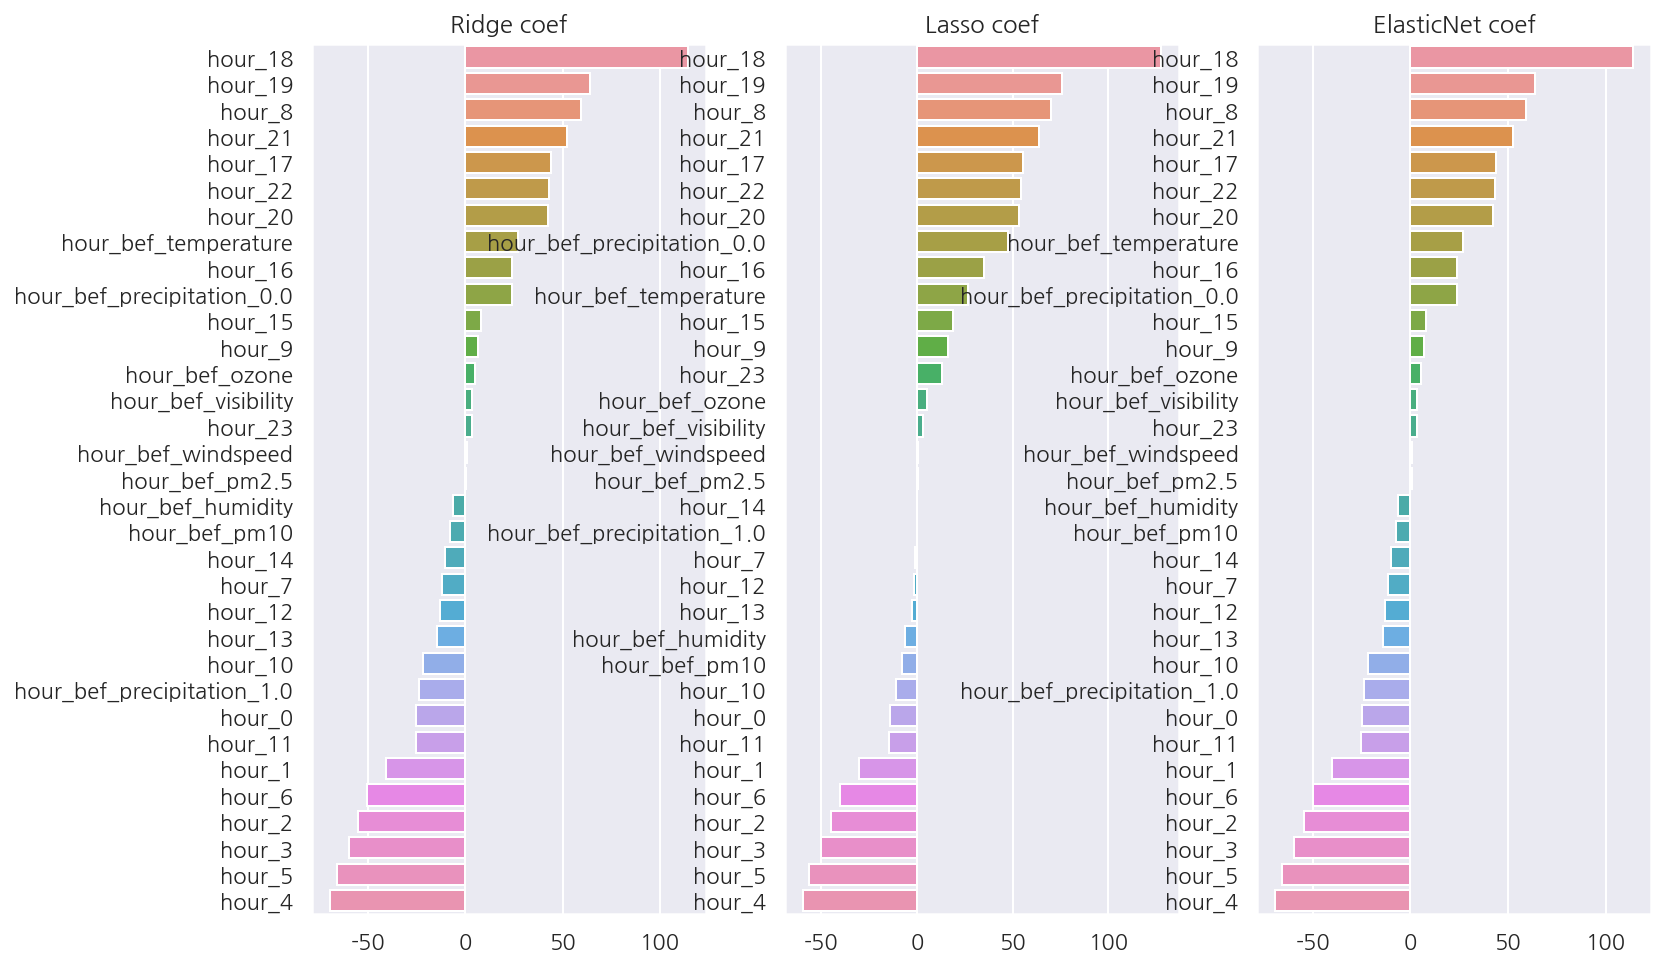

In [20]:
coef = pd.Series(model_ridge.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.title('Ridge coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

coef = pd.Series(model_lasso.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.subplot(1,3,2)
plt.title('Lasso coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

coef = pd.Series(model_elastic.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.subplot(1,3,3)
plt.title('ElasticNet coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

* 이상치 탐색 ** 온도를 구간화 ** 습도 ** 시계?
* 비선형회귀
* 앙상블

In [30]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

################################################

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

## train 전체 학습 
## 제출할 test로 예측
def res_data_preprocessing(data):
    
    # 1차
    # 각 시간대별 평균값으로 결측치 대체
    data['hour_bef_temperature'].fillna(data.groupby('hour')['hour_bef_temperature'].transform('mean'),inplace=True)
    data['hour_bef_windspeed'].fillna(data.groupby('hour')['hour_bef_windspeed'].transform('mean'),inplace=True)
    data['hour_bef_humidity'].fillna(data.groupby('hour')['hour_bef_humidity'].transform('mean'),inplace=True)
    data['hour_bef_visibility'].fillna(data.groupby('hour')['hour_bef_visibility'].transform('mean'),inplace=True)
    data['hour_bef_ozone'].fillna(data.groupby('hour')['hour_bef_ozone'].transform('mean'),inplace=True)
    data['hour_bef_pm10'].fillna(data.groupby('hour')['hour_bef_pm10'].transform('mean'),inplace=True)
    data['hour_bef_pm2.5'].fillna(data.groupby('hour')['hour_bef_pm2.5'].transform('mean'),inplace=True)
    
    # 1차 결측치 삭제 후, ozone, pm10, pm2.5의 hour_1에 해당하는 결측치와 hour_bef_precipitation 결측치만 남음.
    # ozone, pm10, pm2.5 결측값을 hour_0, hour_2의 평균값으로 대체
    for col in ['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']:
        hour_0 = data[data['hour'] == 0][col].mean()
        hour_2 = data[data['hour'] == 2][col].mean()
        res = np.mean([hour_0,hour_2])
        data[col] = data[col].fillna(res)
    
    data['hour_bef_precipitation'].fillna(0,inplace=True)
    # hour_bef_precipitation 결측치 삭제
    # data = data.dropna()
    
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = data.loc[:,:] # 결측값 제거 # 피처 선택
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    res_preprocessed_features = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_preprocessed_features[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # return res_df
    return res_preprocessed_features

    
# get final preprocessed train/test    
res_train = res_data_preprocessing(train)
res_target = res_train['count']
res_train = res_train.drop(['count'],axis=1)

res_test = res_data_preprocessing(test)

# res _ model

model_res_1 = LinearRegression()

model_res_1.fit(res_train,res_target)

res_1_predict = model_res_1.predict(res_test)

In [44]:
submission['count'] = res_1_predict
submission

,id,count
0,0,70.058594
1,1,210.152344
2,2,-12.234375
3,4,37.089844
4,5,34.843750
...,...,...
710,2148,76.347656
711,2149,34.863281
712,2165,122.082031
713,2166,159.175781


In [45]:
submission.to_csv('res_model_1.csv',index=False)

In [58]:
residual.sort_values(by='diff',ascending=False).head(30)

,label,predict,diff
19,15.0,162.890625,147.890625
603,8.0,142.593750,134.593750
978,238.0,124.796875,113.203125
31,258.0,148.046875,109.953125
4,431.0,321.421875,109.578125
216,203.0,93.562500,109.437500
211,46.0,153.062500,107.062500
1394,398.0,294.453125,103.546875
587,235.0,137.000000,98.000000
264,300.0,206.234375,93.765625
